## Implementation of following: Comparison
### Leverage score
### Kmeans (Local Landmark Selection)
### Kmeans++ (probablistic || parallel KMeans++)
### Time taken by each algorithm

## ------------------------------------

#### Few important libraries
##### sklearn.utils.extmath.randomized_svd


#### ----------------------------------------
##### axis = 0 across columns
##### axis = 1/-1 across row
##### np.sum(np.abs(x)**2,axis=-1/1) for computing l2norm of each row of matrix

In [391]:
%matplotlib inline 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import timeit,time
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression

#### Execution

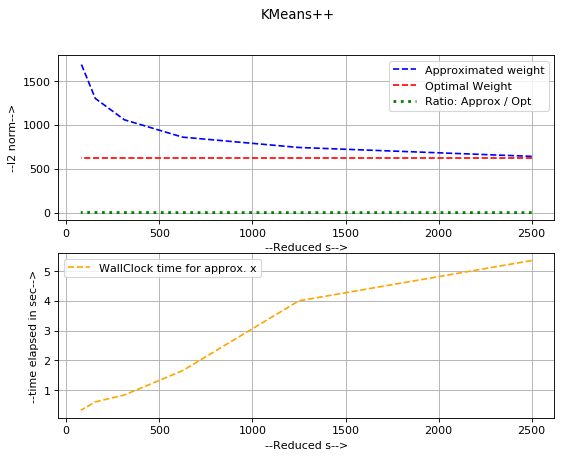

In [470]:
#%time
n = int(input('Enter the column dimension (# fo row): '))
d = int(input('Enter the row dimension(# of column > 20): '))
name = input('Enter the sketching technique: ')
A,b = syntheticData(n,d)
controller(A,b,name)

#### Controller

In [378]:
def controller(A,b,name):
    if name == 'lss':
        LSS(A,b)
    elif name=='kpp':
        Kpp(A,b)
    elif name == 'lms':
        LMS(A,b)
    elif name == 'uss':
        USS(A,b)

##### Leverage Score Sampling

In [465]:
#%time
def LSS(A,b):
    l2norm=list() #for storing l2 norm across various size changes
    l2normOpt=list() # optimal
    ratio = list()
    t =list()
    row,col = A.shape
    s = [row/2,row/4,row/8,row/16,row/32,row/64]
    s = [round(x) for x in s]
    u,e,vt = np.linalg.svd(A,full_matrices=False)
    leveragescore = np.sum(np.abs(u)**2,axis=1) # for rows the matrix considered is column :
    prob = leveragescore/sum(leveragescore)
    for i in s:
        start = time.time()
        index = np.random.choice(row,i,replace = False,p=prob)
        C = A[index,:] # selcting s rows
        A_sketch = C
        b_sketch = b[index]
    #-------------- calling regression function -----------#
        x_tilde = regression(A_sketch,b_sketch)
        end = time.time() # time is only calculated for find approximate x
        x_opt = regression(A,b)
        
        #compute l2 norm: square of l2 norm
        l2norm.append(np.linalg.norm((A.dot(x_tilde)-b),ord=2))
        l2normOpt.append(np.linalg.norm((A.dot(x_opt)-b),ord=2))
        t.append(end-start)
        
    ratio = np.array(l2norm)/np.array(l2normOpt)
    plotting(s,l2norm,l2normOpt,ratio,t,'Leverage Score Sampling')

##### LandMark Sampling Selection

In [450]:
# LandMark Selection : which is essentially k-means clustering
def LMS(A,b):
    l2norm = list()  # this is for sketched
    l2normOpt=list() # optimal
    ratio = list()
    t=list()
    row,col=A.shape
    aug_A = np.c_[A,b]
    s = [row/2,row/4,row/8,row/16,row/32,row/64]
    s= [round(x) for x in s]
    for i in s:
        start = time.time()
        k_cluster=KMeans(n_clusters=i,init='random',n_init=1,random_state=0).fit(aug_A)
        C = k_cluster.cluster_centers_
        A_sketch = C[:,:-1] # placing the first d columns in A sketch
        b_sketch = C[:,-1]  #placing the (d+1)th column in b
        x_tilde = regression(A_sketch,b_sketch)
        end = time.time()
        x_opt = regression(A,b) 
        
        l2norm.append(np.linalg.norm((A.dot(x_tilde)-b),ord=2))
        l2normOpt.append(np.linalg.norm((A.dot(x_opt)-b),ord=2))
        t.append(end-start) # only for sketched matrix
        
    ratio = np.array(l2norm)/np.array(l2normOpt)
    plotting(s,l2norm,l2normOpt,ratio,t,'Local Landmark Selection')

##### KMeans ++ Sampling
###### class sklearn.cluster.KMeans(n_clusters=8, init=’k-means++’, n_init=10, max_iter=300, tol=0.0001, precompute_distances=’auto’, verbose=0, random_state=None, copy_x=True, n_jobs=1, algorithm=’auto’)[source]

In [471]:
# KMeans++ Selection
def Kpp(A,b):
    l2norm = list()  # this is for sketched
    l2normOpt=list() # for optimal
    ratio = list()
    t=list()
    row,col=A.shape
    s = [row/2,row/4,row/8,row/16,row/32,row/64]
    s = [round(x) for x in s]
    aug_A = np.c_[A,b]
    for i in s:
        start=time.time()
        k_cluster=KMeans(n_clusters=i,init='k-means++',n_init=1,random_state=0).fit(aug_A)
        C = k_cluster.cluster_centers_
        A_sketch = C[:,:-1] # placing the first d columns in A sketch
        b_sketch = C[:,-1]#placing the (d+1)th column in b
        x_tilde = regression(A_sketch,b_sketch)
        end=time.time()
        x_opt = regression(A,b)
        
        l2norm.append(np.linalg.norm((A.dot(x_tilde)-b),ord=2))
        l2normOpt.append(np.linalg.norm((A.dot(x_opt)-b),ord=2))
        t.append(end-start)
    ratio = np.array(l2norm)/np.array(l2normOpt)
    plotting(s,l2norm,l2normOpt,ratio,t,'KMeans++')

##### Uniform Sampling

In [469]:
def USS(A,b):
    l2norm = list()  # this is for sketched
    l2normOpt=list() # optimal
    ratio = list()
    t=list()
    row,col = A.shape
    #u,e,vt = np.linalg.svd(A)
    s = [row/2,row/4,row/8,row/16,row/32,row/64]
    s = [round(x) for x in s]
    for i in s:
        start = time.time()
        index = np.random.choice(row,i)
        A_sketch = A[index,:]# called C also
        b_sketch = b[index]
        x_tilde = regression(A_sketch,b_sketch)
        end = time.time()
        x_opt = regression(A,b)
        
        l2norm.append(np.linalg.norm((A.dot(x_tilde)-b),ord=2))
        l2normOpt.append(np.linalg.norm((A.dot(x_opt)-b),ord=2))
        t.append(end-start)
    ratio = np.array(l2norm)/np.array(l2normOpt)
    plotting(s,l2norm,t,'Uniform Sampling')

##### Regression Model

In [58]:
def regression(A,b):
    regression_model = LinearRegression()
    regression_model.fit(A,b)
    #x_tilde=regression_model.coef_
    return regression_model.coef_

##### Plotting

In [466]:

def plotting(x,y1,y2,r,t,name):
    # Create a figure of size 8x6 inches, 80 dots per inch
    plt.figure(figsize=(8, 6), dpi=80)
    # Create a new subplot from a grid of 1x1
    plt.subplot(2, 1, 1)
    plt.plot(x, y1, color="blue", linewidth=1.5, linestyle="--",label='Approximated weight')
    plt.plot(x,y2,color="red",linewidth=1.5,linestyle="--",label='Optimal Weight')
    plt.plot(x,r,color="green",linewidth=2.5,linestyle=":",label='Ratio: Approx / Opt')
    plt.legend()
    plt.grid(b=True)
    plt.ylabel('--l2 norm-->')
    plt.xlabel('--Reduced s-->')

    plt.subplot(2,1,2)
    plt.plot(x,t,color="orange",linewidth = 1.5,linestyle="--",label='WallClock time for approx. x')
    plt.ylabel('--time elapsed in sec-->')
    plt.xlabel('--Reduced s-->')
    plt.grid(b=True)
    plt.legend()
    plt.suptitle(name)
    plt.show()


#### Synthetic data : uniform leverage score
##### y = Xw+e
##### Using multivariate distribution : N(1d,C)
##### C = 2*0.5^|i-j|  : covariance matrix
##### w =(1_10;0.1*1_p-20;1_10)_p


In [364]:
## create a dxd covariance matrix
def syntheticData(n,d):
    C = np.zeros((d,d)) # covariance matrix
    for i in range(d):
        for j in range(d):
            C[i][j] = 2*(0.5**abs(i-j))
    mean = np.ones(d)
    X = np.random.multivariate_normal(mean,C,(n)) # this is A
    beta = list()
    beta.extend(np.ones(10))
    beta.extend(0.1*np.ones(d-20))
    beta.extend(np.ones(10))
    beta = np.array(beta)
    noise = np.random.normal(loc=0.0,scale =9,size=n)
    y = X.dot(beta) + noise # this is b
    return X,y
    #np.append(beta,[np.ones(10),0.1*np.ones(d-10),np.ones(10)])

In [423]:
%time print('hey')

hey
CPU times: user 116 µs, sys: 120 µs, total: 236 µs
Wall time: 213 µs


## Testing Zone

In [164]:
row =5 
s= 3
prob=[0.1,0.3,0.4,0.05,0.15]
t = np.random.choice(row,s,replace = False,p=prob)
type(t)
A[t,:]

array([[ 1.75811943,  1.54954639,  2.6442936 ,  1.51673231,  1.55026645,
         0.46475255,  2.16283805,  1.76447889,  2.48482352,  1.85005404,
         1.63156451,  2.46741751,  2.1626332 ,  2.57749377,  0.56048549],
       [-0.31632761, -1.48294863, -0.02637224,  0.6316264 , -0.49344282,
        -0.91150865,  0.83951405,  2.42119026,  1.77451533,  0.83000451,
         0.95025106,  1.3706396 ,  0.65908859,  1.33490888, -0.52697512],
       [ 0.48441224, -1.17136266,  0.37613794,  0.46361879,  0.18704962,
         0.23222046,  2.44639495,  0.51797345,  0.39837807, -0.41673073,
         0.78455793,  0.99914945, -0.52585746, -0.62295193, -1.22412704]])

In [173]:
t = [1.25,0.5]
t = [round(x) for x in t]
t

[1, 0]

In [180]:
np.arange(5)

array([0, 1, 2, 3, 4])

In [335]:
t=np.random.randint(2,10,(3,4))

In [443]:
x = [2,4,8]
x=np.array(x)
y = [2,4,8]
y=np.array(y)
x/y

array([1., 1., 1.])

In [337]:
 _2norm = np.sum(np.abs(t)**2,axis=1)**(1./2)

In [338]:
_2norm

array([ 6.08276253, 13.22875656, 14.2126704 ])

In [261]:
 _2norm = np.sum(np.abs(t)**2,axis=-1)**(1./2)

In [262]:
_2norm

array([ 7.21110255, 15.71623365, 11.61895004])

In [263]:
sum(_2norm)

34.54628623505194

In [284]:
t.dot([1,2,3,4])

array([32, 83, 60])

[]

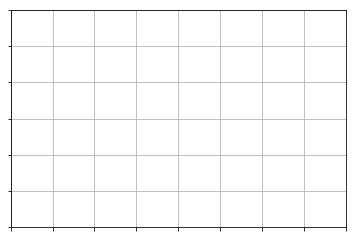

In [315]:
axes = plt.gca()
plt.grid(b=True)
axes.set_xlim(0, 4)
axes.set_ylim(0, 3)
axes.set_xticklabels([])
axes.set_yticklabels([])